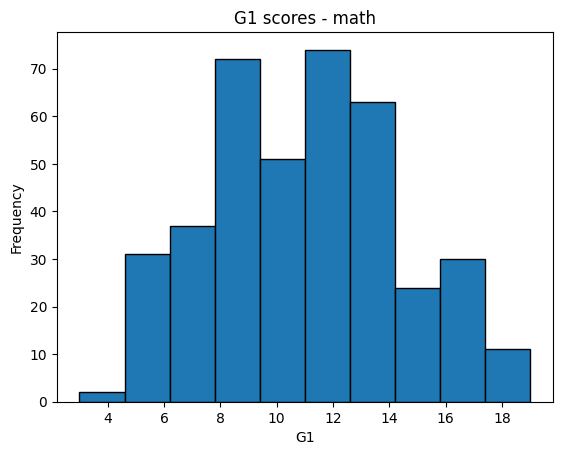

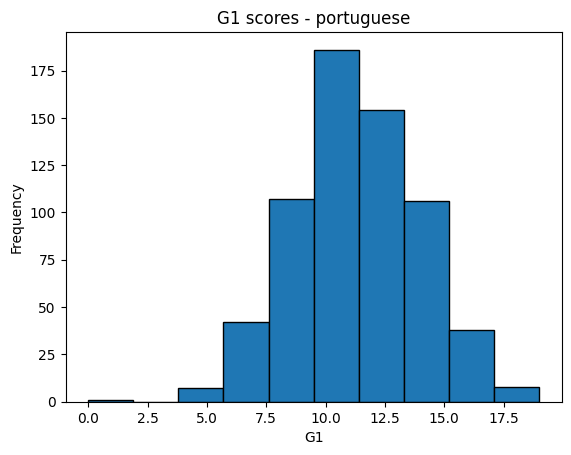

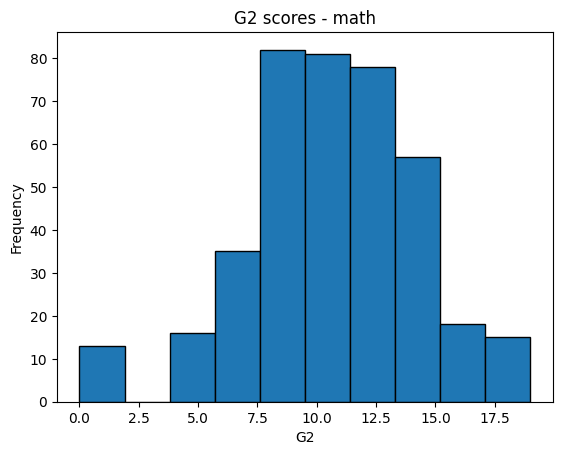

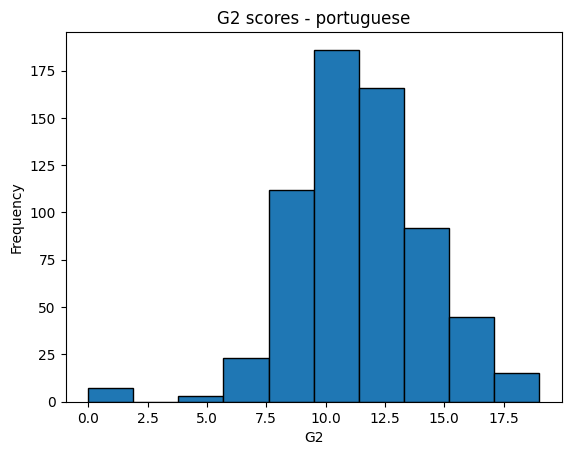

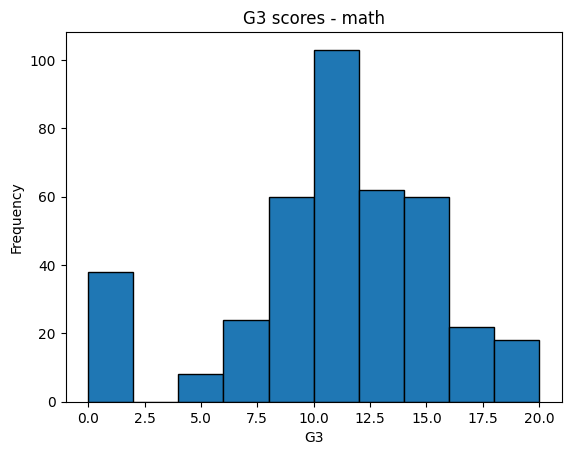

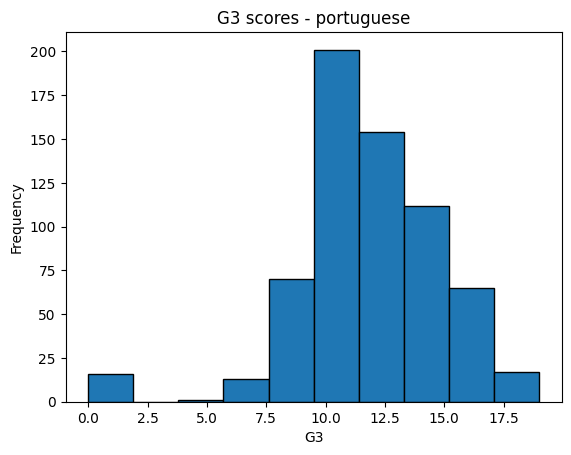

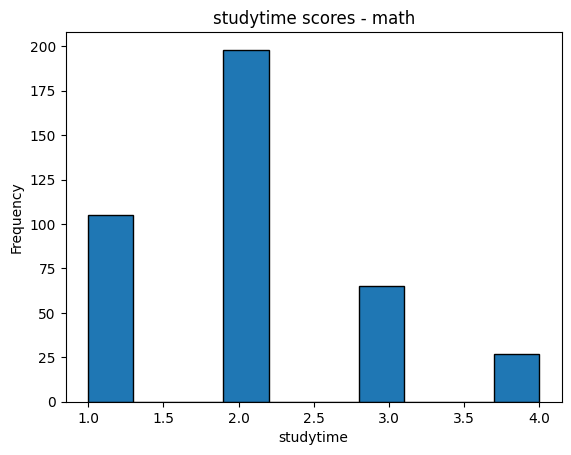

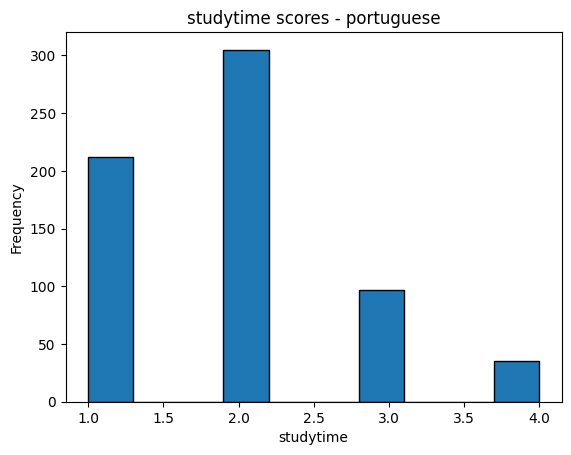

alt.VConcatChart(...)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import numpy as np
from pygments.lexer import include
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Load and process data
columns = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime',
           'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel',
           'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']
mat_data = pd.read_csv('/Users/lexjiang/Downloads/datasets/student-mat.csv', sep=';', names=columns, header=0)
por_data = pd.read_csv('/Users/lexjiang/Downloads/datasets/student-por.csv', sep=';', names=columns, header=0)

# Convert grades to numeric
for df in [mat_data, por_data]:
    df['G3'] = pd.to_numeric(df['G3'], errors='coerce')

# Validate numeric conversions
mat_data['G3'] = mat_data['G3'].fillna(0).astype(int)
por_data['G3'] = por_data['G3'].fillna(0).astype(int)

# Plot histograms for G1, G2, G3, and studytime for both datasets
for col in ['G1', 'G2', 'G3', 'studytime']:
    for data, subject in [(mat_data, 'math'), (por_data, 'portuguese')]:
        plt.hist(data[col], bins=10, edgecolor='black')
        plt.title(f'{col} scores - {subject}')
        plt.xlabel(f'{col}')
        plt.ylabel('Frequency')
        plt.show()

# Altair scatter plots with regression for math dataset
scatter_plots = [
    ('age', 'G3'),
    ('failures', 'G3'),
    ('G1', 'G3'),
    ('G2', 'G3')
]

charts = []
for x, y in scatter_plots:
    chart = alt.Chart(mat_data).mark_circle().encode(x=f'{x}:Q', y=f'{y}:Q')
    chart = chart + chart.transform_regression(x, y).mark_line(color='red')
    charts.append(chart)

charts_display = charts[0] & charts[1] & charts[2] & charts[3]
charts_display

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

def forward_regression(X, y, initial_list=None, threshold_in=0.01, threshold_out=0.05, verbose=True):
    if initial_list is None:
        initial_list = []
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = {}
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        if new_pval:
            best_feature, best_pval = min(new_pval.items(), key=lambda item: item[1])
            if best_pval < threshold_in:
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add {best_feature} with p-value {best_pval}')
        if not changed:
            break
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:]
            worst_feature = pvalues.idxmax()
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Remove {worst_feature} with p-value {worst_pval}')
    return included

In [10]:
def backward_regression(X, y, threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        model = sm.OLS(y, sm.add_constant(X[included])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"Drop {worst_feature} with p-value {worst_pval}")
        else:
            break
    return included

In [12]:
def stepwise_selection(X, y, initial_list=None, threshold_in=0.01, threshold_out=0.05, verbose=True):
    if initial_list is None:
        initial_list = []
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))

        # Forward Step
        new_pval = {new_column: sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit().pvalues[new_column] for new_column in excluded}
        if new_pval:
            best_feature, best_pval = min(new_pval.items(), key=lambda item: item[1])
            if best_pval < threshold_in:
                included.append(best_feature)
                changed = True
                if verbose:
                    print(f'Add {best_feature} with p-value {best_pval}')

        # Backward Step
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:]
            worst_feature = pvalues.idxmax()
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                included.remove(worst_feature)
                changed = True
                if verbose:
                    print(f'Remove {worst_feature} with p-value {worst_pval}')

        if not changed:
            break

    return included

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Select all quantitative variables
quantitative_vars = por_data.select_dtypes(include=['number']).columns.tolist()
X_por = por_data[quantitative_vars].drop(columns=['G3'])
y_por = por_data['G3']

# Perform Forward, Backward, and Stepwise Regression
forward_features = forward_regression(X_por, y_por, verbose=False)
backward_features = backward_regression(X_por, y_por, verbose=False)
stepwise_features = stepwise_selection(X_por, y_por, verbose=False)

# Evaluate models
def evaluate_rmse(X, y, features):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, random_state=0, train_size=0.75)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return sqrt(mean_squared_error(y_test, predictions))

rmse_forward = evaluate_rmse(X_por, y_por, forward_features)
rmse_backward = evaluate_rmse(X_por, y_por, backward_features)
rmse_stepwise = evaluate_rmse(X_por, y_por, stepwise_features)

print("RMSE Forward Selection:", rmse_forward)
print("RMSE Backward Selection:", rmse_backward)
print("RMSE Stepwise Selection:", rmse_stepwise)
print(forward_features,backward_features,stepwise_features)

RMSE Forward Selection: 1.126324587529237
RMSE Backward Selection: 1.1054002374799041
RMSE Stepwise Selection: 1.126324587529237
['G2', 'G1'] ['failures', 'Dalc', 'absences', 'G1', 'G2'] ['G2', 'G1']


In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Select all quantitative variables
quantitative_vars = mat_data.select_dtypes(include=['number']).columns.tolist()
X_mat = mat_data[quantitative_vars].drop(columns=['G3'])
y_mat = mat_data['G3']

# Perform Forward, Backward, and Stepwise Regression
forward_features = forward_regression(X_mat, y_mat, verbose=False)
backward_features = backward_regression(X_mat, y_mat, verbose=False)
stepwise_features = stepwise_selection(X_mat, y_mat, verbose=False)

# Evaluate models
def evaluate_rmse(X, y, features):
    X_train, X_test, y_train, y_test = train_test_split(X[features], y, random_state=0, train_size=0.75)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return sqrt(mean_squared_error(y_test, predictions))

rmse_forward = evaluate_rmse(X_mat, y_mat, forward_features)
rmse_backward = evaluate_rmse(X_mat, y_mat, backward_features)
rmse_stepwise = evaluate_rmse(X_mat, y_mat, stepwise_features)

print("RMSE Forward Selection:", rmse_forward)
print("RMSE Backward Selection:", rmse_backward)
print("RMSE Stepwise Selection:", rmse_stepwise)
print(forward_features,backward_features,stepwise_features)

RMSE Forward Selection: 2.465727749952999
RMSE Backward Selection: 2.4226853845100464
RMSE Stepwise Selection: 2.465727749952999
['G2', 'famrel', 'absences'] ['age', 'famrel', 'absences', 'G1', 'G2'] ['G2', 'famrel', 'absences']
